# Self-supervised attempt

/home/giacomo.t/.conda/envs/sr_gt_cuda116/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Collected # paired HR data:  25


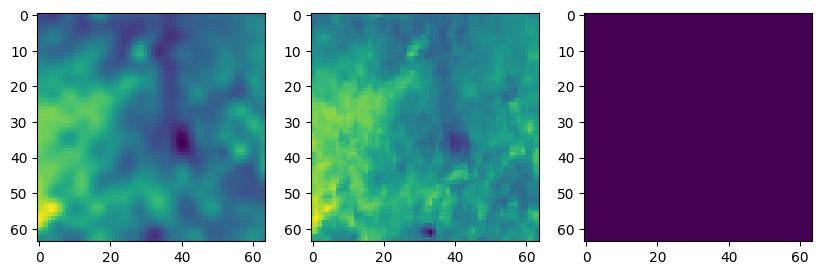

In [1]:
import os
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from pyhdf.SD import SD, SDC
from piqa import SSIM

from dloader import *

from srcnn import *
from unet import *
from resunet import *
from haunet import *
from mrunet import *

DEVICE  = "cuda:0" if torch.cuda.is_available() else "cpu"

PATH_LR = "/mnt/LOCALDATA/STUDENTS/SATELLITE/MODIS/MOD11B1"
PATH_HR = "/mnt/LOCALDATA/STUDENTS/SATELLITE/MODIS/MOD11A1"
QA      = "/home/giacomo.t/src/scanning_paired_dataset.csv"
PARAMS  = "/home/giacomo.t/src/train_params_tiles_2019_2020_2021_2022.csv"
UP_SCALE = 6
KERNEL_SIZE = 5
SEED = 8609

# Build model
model = build_unet(1, False)
model = model.to(DEVICE)

# Load sample image
mds = MODIS_dataset_single(
    hr_filepath=PATH_HR,
    qa=QA,
    zerof_thr=0.01,
    cloud_thr=0.01,
    error_thr=0.01,
    impute_thr=0.01,
    up_scale=4,
    kernel_size=KERNEL_SIZE,
    train_params=PARAMS,
    data_set="train",
    seed=SEED)

imgindex = 2

dl  = torch.utils.data.DataLoader(mds, batch_size=1, shuffle=False, num_workers=4)
dl = iter(dl)
for _ in range(imgindex):
    lr, hr, bm = dl.__next__()
    
_, axs = plt.subplots(1,3,figsize=(10,10))
axs[0].imshow(lr.to("cpu").squeeze())
axs[1].imshow(hr.to("cpu").squeeze())
axs[2].imshow(bm.to("cpu").squeeze())
plt.show()

percentage of zero-filled: 0.0002722222125157714
data range  {min, max}:  288.5199890136719 317.4200134277344
data range  {min, max}:  0.9089533686637878 1.0
data params {mean, std}: 0.9551867246627808 0.010195571929216385


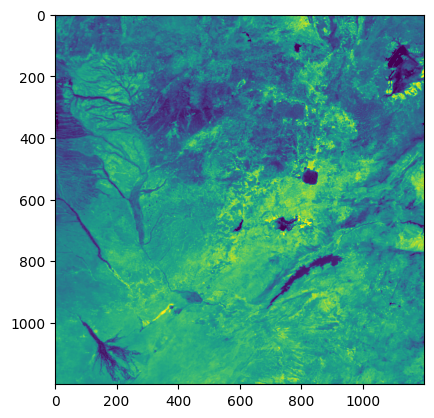

In [2]:
# Reading
filename = mds.qa.iloc[imgindex].hr_files
data = SD(os.path.join(PATH_HR, filename), SDC.READ)
data = data.select("LST_Day_1km")[:,:].astype(np.float64)
data = torch.Tensor(data*0.02)

# Preprocessing

# Imputing zerofilled
print("percentage of zero-filled:", torch.where(data==0, 1, 0).float().mean().item())
data = torch.where(data==0, data[data!=0].mean(), data)

# Rescaling by the highest value
print("data range  {min, max}: ", data.min().item(), data.max().item())
datamin, datamax = data.min().item(), data.max().item()
data = data / datamax

# Collect lower and upper limit for visualisation purposes
print("data range  {min, max}: ", data.min().item(), data.max().item())
datamean, datastd = data.mean().item(), data.std().item()
llim, ulim = datamean-3*datastd , datamean+3*datastd

print("data params {mean, std}:", datamean, datastd)
plt.imshow(data, vmin=llim, vmax=ulim)
plt.show()

## Perform subpatch extraction

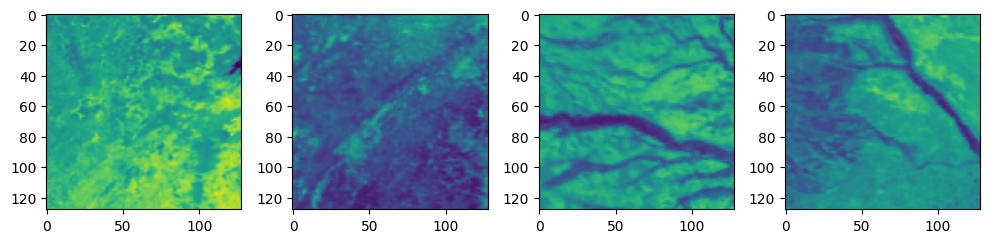

In [3]:
import torchvision.transforms as tt
patch_size = (128, 128)

nimages = 4
subpatch = [tt.Compose([tt.RandomCrop(patch_size)])(data) for _ in range(nimages)]

_, axs = plt.subplots(1, nimages, figsize=(10,8))
for i in range(nimages):
    axs[i].imshow(subpatch[i], vmin=llim, vmax=ulim)
plt.tight_layout()
plt.show()

## Degradation

/home/giacomo.t/.conda/envs/sr_gt_cuda116/lib/python3.9/site-packages/torch/_tensor.py:761: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


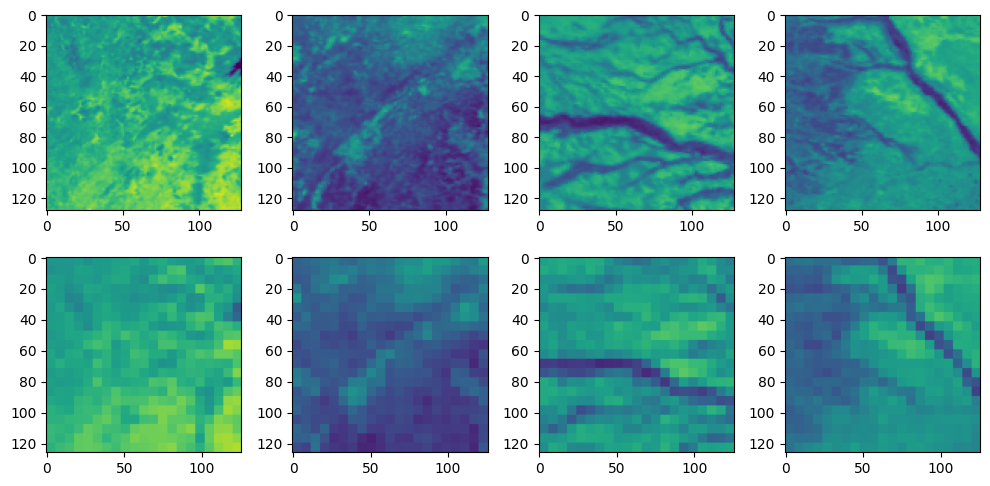

In [4]:
def degrade(x, sf):
    x = x.resize(1,1,x.shape[-2], x.shape[-1])
    x = F.interpolate(x, scale_factor=1/sf, mode="bicubic", antialias=True)
    #x = tt.Compose([tt.GaussianBlur(5)])(x)
    x = F.interpolate(x, scale_factor=sf, mode="nearest-exact", antialias=False)
    return x.squeeze()

scale_factor = 6

child_subpatches = [degrade(subpatch[i], scale_factor) for i in range(len(subpatch))]

_, axs = plt.subplots(2, nimages, figsize=(10,5))
for i in range(nimages):
    axs[0][i].imshow(subpatch[i], vmin=llim, vmax=ulim)
for i in range(nimages):
    axs[1][i].imshow(child_subpatches[i], vmin=llim, vmax=ulim)
plt.tight_layout()
plt.show()

## Perform training

In [26]:
class MEA(torch.nn.Module):
    def __init__(self, imputed_weight:float = 0):
        super(MEA, self).__init__()
        self.imputed_weight = imputed_weight

    def forward(self, x, y):
        mae = torch.abs(torch.subtract(x,y)).float().mean()
        return mae


def degrade(x, sf):
    # if haunet is used: do not rescale back to target dim
    x = F.interpolate(x, scale_factor=1/sf, mode="bicubic", antialias=True)
    #x = tt.Compose([tt.GaussianBlur(3)])(x)
    #x = F.interpolate(x, scale_factor=sf, mode="nearest-exact", antialias=False)
    return x

def get_parents_child(hr, patch_size, scale_factor, batch_size):
    parents = torch.cat([tt.Compose([tt.RandomCrop(patch_size)])(hr).unsqueeze(0).unsqueeze(0) for _ in range(batch_size)], 0)
    child   = degrade(parents, scale_factor)
    return parents, child

def get_loss():
    #return MEA()
    return torch.nn.MSELoss()

def get_optim(lr):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0)
    return optimizer

def get_scheduler(optimizer):
    #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
        factor=0.1, patience=10, threshold=0.0000001, threshold_mode='abs')
    return scheduler

def build_model():
    #model = MRUNet(res_down=True, n_resblocks=16, bilinear=0).to(DEVICE)
    model = build_haunet(scale_factor=scale_factor, nchannels=1, multi_image=False)
    model = model.to(DEVICE)
    return model

hr = data.to(DEVICE)
patch_size = (64,64)
batch_size = 1
scale_factor = 4

model = build_model()
loss_function = get_loss()
optimizer = get_optim(lr = 0.001)
scheduler = get_scheduler(optimizer)

parents, child = get_parents_child(hr, patch_size, scale_factor, batch_size)

In [29]:
nepochs = 100

model.train()
progression_bar = tqdm(range(nepochs), total=nepochs)
for e in progression_bar:
    
    #parents, child = get_parents_child(hr, patch_size, scale_factor, batch_size)
    
    output = model(child).to(DEVICE)
    
    loss = loss_function(parents, output) # db
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    scheduler.step(loss.item())
    
    progression_bar.set_postfix_str(f" Training Loss « {(loss.item())} »")

100%|██████████| 100/100 [00:25<00:00,  3.98it/s,  Training Loss « 1.5430852727149613e-05 »]


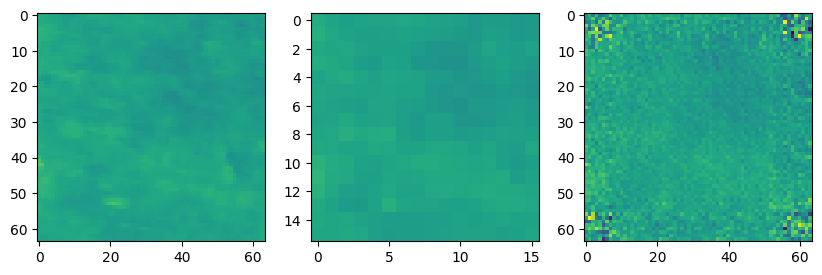

In [30]:
# Example plotting
if batch_size == 1:
    _, axs = plt.subplots(1, 3, figsize=(10,8))
    axs[0].imshow(parents.detach().to("cpu").squeeze(), vmin=llim, vmax=ulim)
    axs[1].imshow(child.detach().to("cpu").squeeze(), vmin=llim, vmax=ulim)
    axs[2].imshow(output.detach().to("cpu").squeeze(), vmin=llim, vmax=ulim)
    
else:
    nimages = 4
    _, axs = plt.subplots(3, nimages, figsize=(10,8))
    for i in range(nimages):
        axs[0][i].imshow(parents[i,:,:,:].detach().to("cpu").squeeze(), vmin=llim, vmax=ulim)
    for i in range(nimages):
        axs[1][i].imshow(child[i,:,:,:].detach().to("cpu").squeeze(), vmin=llim, vmax=ulim)
    for i in range(nimages):
        axs[2][i].imshow(output[i,:,:,:].detach().to("cpu").squeeze(), vmin=llim, vmax=ulim)
    plt.tight_layout()
    plt.show()

In [84]:
parents, child = get_parents_child(hr, patch_size, scale_factor, batch_size)

model.eval()
with torch.no_grad():
    inference = model(child)

In [13]:
#testing haunet
parents, child = get_parents_child(hr, patch_size, scale_factor, batch_size=1)
model(child).shape

torch.Size([1, 1, 128, 128])

# Testing ZSSR using RGB image

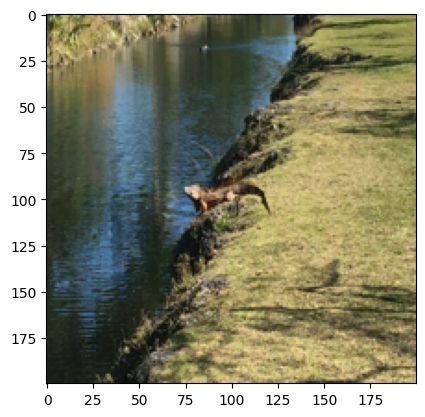

In [114]:
# Testing zsrr with alligator.jpg
import PIL as PIL
img = ttf.to_tensor(PIL.Image.open("alligator.jpg").convert("RGB").resize((200,200)))
img = img.unsqueeze(0)
plt.imshow(ttf.to_pil_image(img.squeeze()))
plt.show()

In [115]:
#define model
import torch
import torch.nn as nn

class ZSSRNet(nn.Module):
	def __init__(self, input_channels=3, kernel_size=3, channels=64):
		 super(ZSSRNet, self).__init__()
		 self.conv0 = nn.Conv2d(input_channels, channels, kernel_size=kernel_size, padding=kernel_size//2, bias=True)
		 self.conv1 = nn.Conv2d(channels, channels, kernel_size=kernel_size, padding=kernel_size//2, bias=True)
		 self.conv2 = nn.Conv2d(channels, channels, kernel_size=kernel_size, padding=kernel_size//2, bias=True)
		 self.conv3 = nn.Conv2d(channels, channels, kernel_size=kernel_size, padding=kernel_size//2, bias=True)
		 self.conv4 = nn.Conv2d(channels, channels, kernel_size=kernel_size, padding=kernel_size//2, bias=True)
		 self.conv5 = nn.Conv2d(channels, channels, kernel_size=kernel_size, padding=kernel_size//2, bias=True)
		 self.conv6 = nn.Conv2d(channels, channels, kernel_size=kernel_size, padding=kernel_size//2, bias=True)
		 self.conv7 = nn.Conv2d(channels, input_channels, kernel_size=kernel_size, padding=kernel_size//2, bias=True)
		 self.relu = nn.ReLU()

	def forward(self, x):
		x = self.relu(self.conv0(x))
		x = self.relu(self.conv1(x))
		x = self.relu(self.conv2(x))
		x = self.relu(self.conv3(x))
		x = self.relu(self.conv4(x))
		x = self.relu(self.conv5(x))
		x = self.relu(self.conv6(x))
		x = self.conv7(x)

		return x

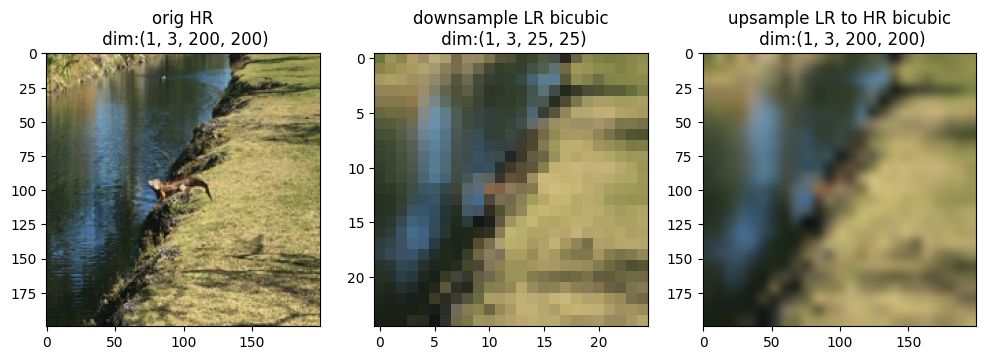

In [141]:
scale_factor = 8
child = F.interpolate(img, scale_factor=1/scale_factor, mode="bicubic", antialias=True)
child_up = F.interpolate(child, scale_factor=scale_factor, mode="bicubic", antialias=True)

# plot
titles = ["orig HR", "downsample LR bicubic", "upsample LR to HR bicubic"]
_, axs = plt.subplots(1,3,figsize=(12,6))
for i,item in enumerate((img, child, child_up)):
    axs[i].imshow(ttf.to_pil_image(item.squeeze()))
    axs[i].set_title(f"{titles[i]}\n dim:{tuple(item.shape)}")
plt.show()

In [142]:
#model = ZSSRNet().to(DEVICE)
model = build_unet(3).to(DEVICE)
#model = build_resunet(3).to(DEVICE)
#model = build_haunet(scale_factor, 3, False).to(DEVICE)
loss_function = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0)

def adjust_learning_rate(optimizer, new_lr):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_lr
        

In [143]:
class PSNR:
    """Peak Signal to Noise Ratio
    img1 and img2 have range [0, 255]"""

    def __init__(self):
        self.name = "PSNR"

    @staticmethod
    def __call__(img1, img2):
        mse = torch.mean((img1 - img2) ** 2)
        return (20 * torch.log10(255.0 / torch.sqrt(mse))).item()


Perform self-supervised training

100%|██████████| 100/100 [00:04<00:00, 22.51it/s,  Training Loss « 0.003949060570448637 »]


Current psnr SR-HR:  92.91812133789062


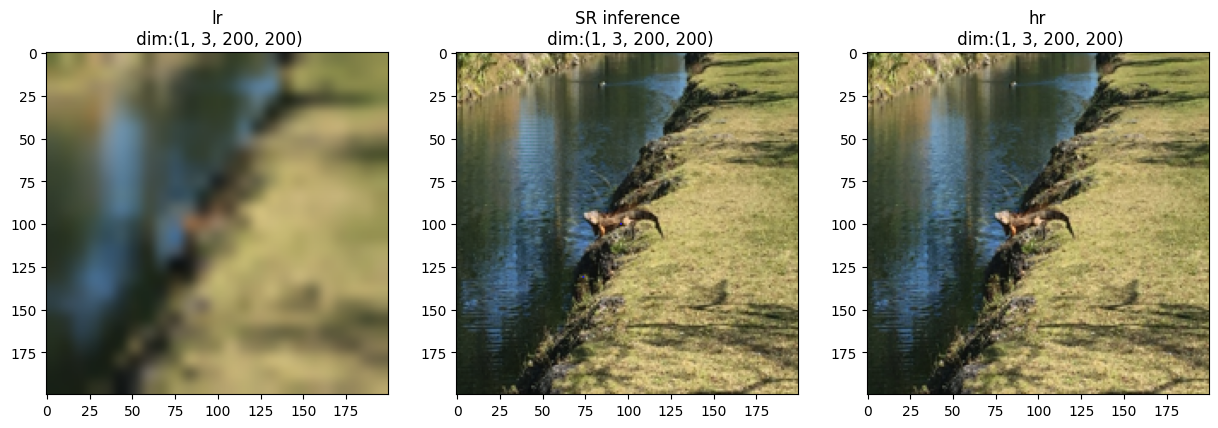

In [155]:
img = img.to(DEVICE)
child = child.to(DEVICE)
child_up = child_up.to(DEVICE)

model.train()
        
nepochs = 100
adjust_learning_rate(optimizer, 0.001)

progression_bar = tqdm(range(nepochs), total=nepochs)
for e in progression_bar:
    output = model(child_up).to(DEVICE)
    loss = loss_function(output, img)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    progression_bar.set_postfix_str(f" Training Loss « {(loss.item())} »")

psnr = PSNR()
print("Current psnr SR-HR: ", psnr(output, img))

# plot
titles = ["lr", "SR inference", "hr"] 
_, axs = plt.subplots(1,3,figsize=(15,6))
for i,item in enumerate((child_up, output, img)):
    axs[i].imshow(ttf.to_pil_image(item.squeeze()))
    axs[i].set_title(f"{titles[i]}\n dim:{tuple(item.shape)}")
plt.show()

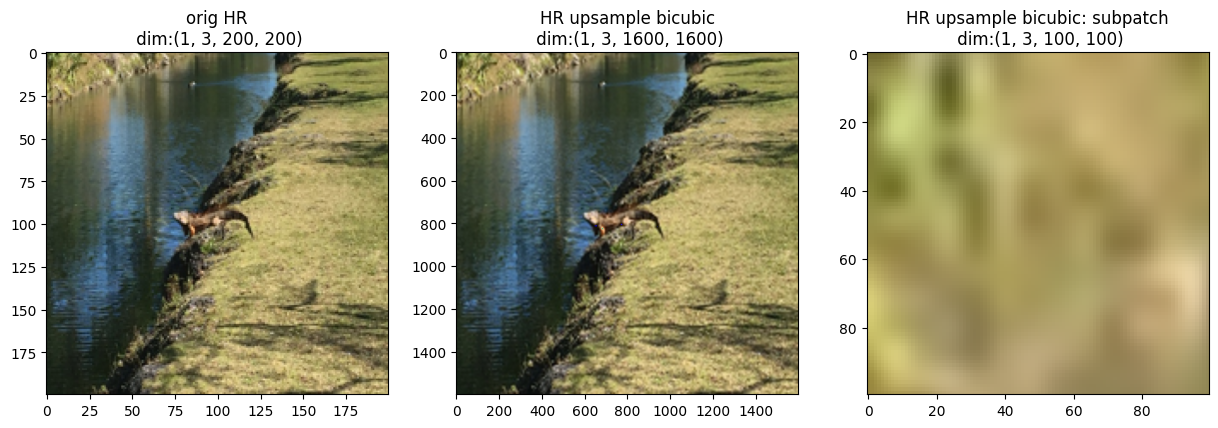

In [161]:
img_up = F.interpolate(img, scale_factor=scale_factor, mode="bicubic", antialias=True)
img_up = img_up.to(DEVICE)

img_up_subpatch = img_up[:,:,100:200,100:200]

# Plot
titles = ["orig HR", "HR upsample bicubic", "HR upsample bicubic: subpatch"] 
_, axs = plt.subplots(1,3,figsize=(15,6))
for i,item in enumerate((img, img_up, img_up_subpatch)):
    axs[i].imshow(ttf.to_pil_image(item.squeeze()))
    axs[i].set_title(f"{titles[i]}\n dim:{tuple(item.shape)}")
plt.show()    

Testing over a subpatch: superresolving to achieve higher resolution over original HR image

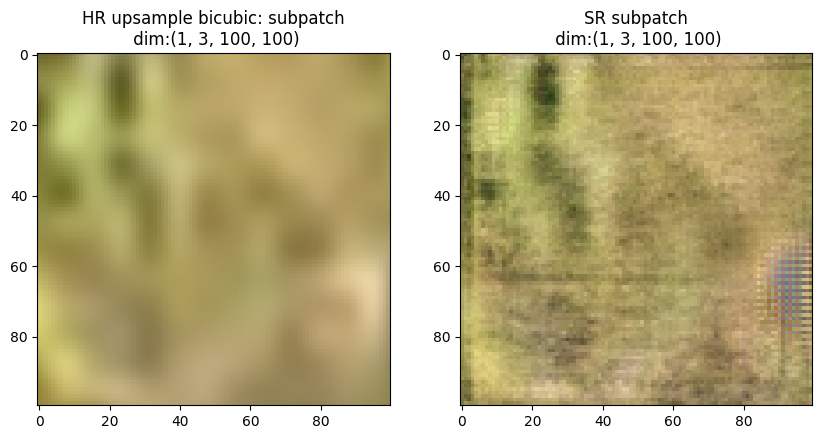

In [162]:
model.eval()
with torch.no_grad():
    inference = model(img_up_subpatch).to(DEVICE)
    

# Plot
titles = ["HR upsample bicubic: subpatch", "SR subpatch"] 
_, axs = plt.subplots(1,2,figsize=(10,6))
for i,item in enumerate((img_up_subpatch, inference)):
    axs[i].imshow(ttf.to_pil_image(item.squeeze()))
    axs[i].set_title(f"{titles[i]}\n dim:{tuple(item.shape)}")
plt.show()   